In [1]:
%matplotlib inline


from neuron import h
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import h5py
import os

from cell_inference.utils.plotting.plot_results import plot_lfp_traces, plot_lfp_heatmap
from cell_inference.utils.feature_extractors.SummaryStats2D import calculate_stats, build_lfp_grid
from cell_inference.cells.stylizedcell import CellTypes
from cell_inference.cells.activecell import ActiveCell
from cell_inference.cells.passivecell import PassiveCell
from cell_inference.cells.simulation import Simulation
from cell_inference.utils.currents.recorder import Recorder
from cell_inference.config import paths, params
from cell_inference.utils.feature_extractors.parameterprediction import ClassifierTypes, ClassifierBuilder

cell_type = CellTypes.ACTIVE

h.nrn_load_dll(paths.COMPILED_LIBRARY)
geo_standard = pd.read_csv(paths.GEO_STANDARD,index_col='id')
h.tstop = params.TSTOP
h.dt = params.DT

In [16]:
from cell_inference.utils.transform.geometry_transformation import hphi2unitsphere


DATA_PATH = 'cell_inference/resources/simulation_data'
TRIAL_PATH = os.path.join(DATA_PATH, 'Loc2Alt_Ori2_Geo3_params')

LFP_PATH = os.path.join(TRIAL_PATH, 'lfp.npz')  # LFP and labels

lfp   = np.load(LFP_PATH)['x']
print(lfp.shape)
labels = np.load(LFP_PATH)['y']
print(labels.shape)

(1000, 176, 384)
(1000, 7)


In [4]:
from tqdm.notebook import tqdm

summ_stats = []
for i in tqdm(range(lfp.shape[0])):
    g_lfp, _ = build_lfp_grid(lfp[i], params.ELECTRODE_POSITION)
    summ_stats.append(calculate_stats(g_lfp))
summ_stats = np.array(summ_stats)

(176, 384)


  0%|          | 0/1000 [00:00<?, ?it/s]

If the user sends h and phi parameters and wants the model to learn directional vectors for orientation, enable this code block

In [5]:
convert_hphi_to_dv = False

if convert_hphi_to_dv:
#     hphi_labels = labels
    dv = hphi2unitsphere(labels)
    dvx, dvy, dvz = tuple(np.hsplit(dv, 3))
    labels = np.concatenate((dvx, dvy, dvz), axis=1)
    print(labels.shape)

In [6]:
import json

CONFIG_PATH = os.path.join(TRIAL_PATH, 'config.json')

with open(CONFIG_PATH, 'r') as f:
    config = json.load(f)

inference_list = config['Trial_Parameters']['inference_list']
print(inference_list)
ranges = config['Simulation_Parameters']['loc_param_range']
ranges.update(config['Simulation_Parameters']['geo_param_range'])
feature_range = (-1, 1)

normalize_labels = True

if normalize_labels:
    for i in range(labels.shape[1]):
        label = labels[:,i]
        label_name = inference_list[i]
        min_max_range = ranges[label_name]
        x_std = (label - min_max_range[0]) / (min_max_range[1] - min_max_range[0])
        x_scaled = x_std * (feature_range[1] - feature_range[0]) + feature_range[0]
        labels[:,i] = x_scaled
    print(labels)

['d', 'theta', 'h', 'phi', 'r_s', 'l_t', 'r_t']
[[-0.54532796  0.19950308  0.2467447  ...  0.78257079 -0.95830196
   0.01884223]
 [-0.36648332 -0.83769703 -0.33564824 ... -0.10318346 -0.03745967
  -0.99991956]
 [ 0.59473091  0.05853246 -0.31366349 ... -0.15249521  0.96449401
  -0.76405391]
 ...
 [-0.26264348 -0.37940062  0.95769607 ...  0.23478598  0.82764779
  -0.75374182]
 [-0.01424659 -0.12016722  0.92645932 ... -0.40433452  0.83934002
   0.84983729]
 [-0.1353533  -0.07019125  0.14896279 ...  0.81742647 -0.38685954
  -0.7928324 ]]


In [7]:
from cell_inference.utils.feature_extractors.helperfunctions import train_regression, build_dataloader_from_numpy

data = summ_stats
print(data.shape)

train_loader, test_loader = build_dataloader_from_numpy(input_arr=data, labels_arr=labels, batch_size=2)

(1000, 40)


In [8]:
from cell_inference.utils.feature_extractors.fullyconnectednetwork import FullyConnectedNetwork, ActivationTypes
from cell_inference.utils.feature_extractors.convolutionalnetwork import ConvolutionalNetwork
import torch

# model1 = ConvolutionalNetwork(in_channels=1, num_labels=2)
# model1 = torch.load('cell_inference/resources/results/pytorch_models/16_23_59__01_04_2022.pt')
model1 = FullyConnectedNetwork(in_features=40, out_features=7)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #torch.device("cpu")
model1.to(device)

train_regression(model1, train_loader, test_loader, 300, learning_rate=0.001, decay_rate=0.99, device=device)

  0%|          | 1/300 [00:01<05:08,  1.03s/it]

Training Loss: 112.86969737708569 Validation Loss: 32.90155690163374


  4%|▎         | 11/300 [00:11<04:59,  1.04s/it]

Training Loss: 78.33764422312379 Validation Loss: 26.248621359467506


  7%|▋         | 21/300 [00:22<05:04,  1.09s/it]

Training Loss: 73.52916959673166 Validation Loss: 25.15835350751877


 10%|█         | 31/300 [00:32<04:38,  1.03s/it]

Training Loss: 70.81279527023435 Validation Loss: 24.881021454930305


 14%|█▎        | 41/300 [00:43<04:27,  1.03s/it]

Training Loss: 67.86957212164998 Validation Loss: 25.5251176469028


 17%|█▋        | 51/300 [00:53<04:17,  1.03s/it]

Training Loss: 64.34736001119018 Validation Loss: 24.506762705743313


 20%|██        | 61/300 [01:04<04:13,  1.06s/it]

Training Loss: 59.83728286251426 Validation Loss: 24.877759277820587


 24%|██▎       | 71/300 [01:14<04:09,  1.09s/it]

Training Loss: 57.04662850499153 Validation Loss: 25.38460334390402


 27%|██▋       | 81/300 [01:25<03:51,  1.06s/it]

Training Loss: 52.00948543101549 Validation Loss: 24.36718699336052


 30%|███       | 91/300 [01:35<03:33,  1.02s/it]

Training Loss: 48.227452674880624 Validation Loss: 25.423563580960035


 34%|███▎      | 101/300 [01:45<03:20,  1.01s/it]

Training Loss: 44.975688157603145 Validation Loss: 25.82240054756403


 37%|███▋      | 111/300 [01:56<03:11,  1.01s/it]

Training Loss: 42.442045168951154 Validation Loss: 25.94643910974264


 40%|████      | 121/300 [02:06<03:02,  1.02s/it]

Training Loss: 39.880206579342484 Validation Loss: 26.092028837651014


 44%|████▎     | 131/300 [02:16<02:54,  1.03s/it]

Training Loss: 37.39035248942673 Validation Loss: 26.794819854199886


 47%|████▋     | 141/300 [02:26<02:41,  1.01s/it]

Training Loss: 34.84782778099179 Validation Loss: 28.003407664597034


 50%|█████     | 151/300 [02:35<02:09,  1.15it/s]

Training Loss: 31.904186440166086 Validation Loss: 28.50016114488244


 54%|█████▎    | 161/300 [02:45<02:22,  1.02s/it]

Training Loss: 30.68414680287242 Validation Loss: 29.881136260926723


 57%|█████▋    | 171/300 [02:55<02:12,  1.03s/it]

Training Loss: 28.92535956390202 Validation Loss: 29.70195423811674


 60%|██████    | 181/300 [03:04<01:54,  1.04it/s]

Training Loss: 27.910869394429028 Validation Loss: 29.831974919885397


 64%|██████▎   | 191/300 [03:15<01:52,  1.03s/it]

Training Loss: 27.113879179582 Validation Loss: 30.11562156677246


 67%|██████▋   | 201/300 [03:25<01:45,  1.06s/it]

Training Loss: 26.143643870484084 Validation Loss: 31.377828430384398


 70%|███████   | 211/300 [03:36<01:32,  1.03s/it]

Training Loss: 25.192148018162698 Validation Loss: 32.265374194830656


 74%|███████▎  | 221/300 [03:46<01:20,  1.02s/it]

Training Loss: 24.897140613757074 Validation Loss: 32.8164181150496


 77%|███████▋  | 231/300 [03:56<01:11,  1.04s/it]

Training Loss: 23.858546786941588 Validation Loss: 33.30674006044865


 80%|████████  | 241/300 [04:07<01:01,  1.04s/it]

Training Loss: 23.240597241558135 Validation Loss: 33.49196795746684


 84%|████████▎ | 251/300 [04:17<00:50,  1.02s/it]

Training Loss: 22.84481112891808 Validation Loss: 33.57844043895602


 87%|████████▋ | 261/300 [04:27<00:39,  1.02s/it]

Training Loss: 22.214221626054496 Validation Loss: 34.333542075008154


 90%|█████████ | 271/300 [04:38<00:29,  1.03s/it]

Training Loss: 21.624424184206873 Validation Loss: 34.713188380002975


 94%|█████████▎| 281/300 [04:48<00:18,  1.00it/s]

Training Loss: 21.202450924087316 Validation Loss: 35.41948712617159


 97%|█████████▋| 291/300 [04:58<00:09,  1.02s/it]

Training Loss: 21.06149589177221 Validation Loss: 35.76483312249184


100%|██████████| 300/300 [05:07<00:00,  1.02s/it]


In [9]:
from sklearn.metrics import r2_score
from cell_inference.utils.transform.geometry_transformation import hphi2unitsphere, unitsphere2hphi, trivarnorm2unitsphere

train_loader, test_loader = build_dataloader_from_numpy(input_arr=data, labels_arr=labels, batch_size=128)

x, y = next(iter(test_loader))
model1.eval()
x = x.to(device)
output = model1(x)
output = output.to("cpu").detach().numpy()
y = y.to("cpu").detach().numpy()

# h_out, phi_out = tuple(np.hsplit(unitsphere2hphi(trivarnorm2unitsphere(np.hstack((output[:,0], output[:,1], output[:,2])))),2))
# h_lab, phi_lab = tuple(np.hsplit(unitsphere2hphi(trivarnorm2unitsphere(np.hstack((y[:,0], y[:,1], y[:,2])))),2))

print("R2: {}".format(r2_score(y, output)))

# print("R2 h: {}".format(r2_score(h_lab, h_out)))
# print("R2 phi: {}".format(r2_score(phi_lab, phi_out)))
print(output.shape)
print(y.shape)

R2: -0.08978619349289499
(128, 7)
(128, 7)


In [10]:
if normalize_labels:
    for i in range(y.shape[1]):
        old_y = y[:,i]
        old_out = output[:,i]
        label_name = inference_list[i]
        min_max_range = ranges[label_name]
        org_y = (((old_y - feature_range[0]) / (feature_range[1] - feature_range[0])) 
                    * (min_max_range[1] - min_max_range[0]) + min_max_range[0])
        
        org_out = (((old_out - feature_range[0]) / (feature_range[1] - feature_range[0])) 
                    * (min_max_range[1] - min_max_range[0]) + min_max_range[0])
        y[:,i] = org_y
        output[:,i] = org_out

<IPython.core.display.Javascript object>


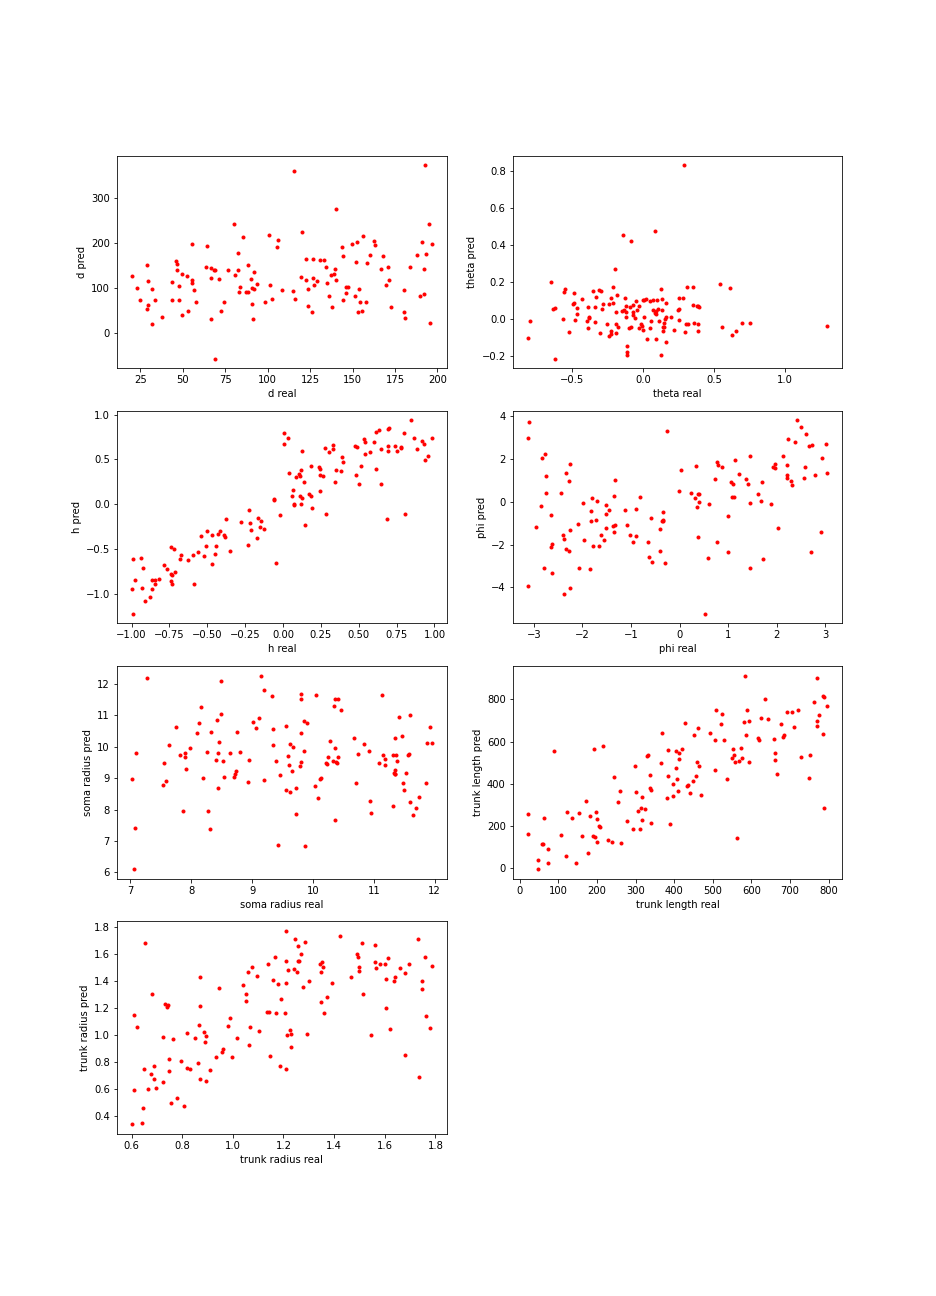

In [12]:
%matplotlib notebook

idx = 0

plt.figure(figsize=(13, 18))

ax_d = plt.subplot(421)
ax_d.scatter(y[:,0], output[:,0], c='red', marker='.')
ax_d.set_xlabel('d real')
ax_d.set_ylabel('d pred')

ax_t = plt.subplot(422)
ax_t.scatter(y[:,1], output[:,1], c='red', marker='.')
ax_t.set_xlabel('theta real')
ax_t.set_ylabel('theta pred')

ax_h = plt.subplot(423)
ax_h.scatter(y[:,2], output[:,2], c='red', marker='.')
ax_h.set_xlabel('h real')
ax_h.set_ylabel('h pred')

ax_p = plt.subplot(424)
ax_p.scatter(y[:,3], output[:,3], c='red', marker='.')
ax_p.set_xlabel('phi real')
ax_p.set_ylabel('phi pred')

ax_lt = plt.subplot(425)
ax_lt.scatter(y[:,4], output[:,4], c='red', marker='.')
ax_lt.set_xlabel('soma radius real')
ax_lt.set_ylabel('soma radius pred')

ax_lt = plt.subplot(426)
ax_lt.scatter(y[:,5], output[:,5], c='red', marker='.')
ax_lt.set_xlabel('trunk length real')
ax_lt.set_ylabel('trunk length pred')

ax_lt = plt.subplot(427)
ax_lt.scatter(y[:,6], output[:,6], c='red', marker='.')
ax_lt.set_xlabel('trunk radius real')
ax_lt.set_ylabel('trunk radius pred')


plt.show()

In [64]:
DATA_PATH = 'cell_inference/resources/invivo'

INVIVO_PATH = os.path.join(DATA_PATH, 'cell377LFP2D.h5')

with h5py.File(INVIVO_PATH, "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    print(f['coord'][:].shape)
    print(f['data'][:].shape)
    a_group_key = list(f.keys())[0]

    # Get the data
    test_data = f['data'][:]

Keys: <KeysViewHDF5 ['coord', 'data', 'fs', 'grid']>
(384, 2)
(121, 384)


In [65]:
np.set_printoptions(suppress=True)

print(params.ELECTRODE_POSITION[:, :2].shape)
print(test_data[i, :].shape)

# g_lfp, _ = build_lfp_grid(test_data, params.ELECTRODE_POSITION)
summ_stats = np.array(calculate_stats(test_data))
print(summ_stats.shape)

model1.eval()
summ_stats = torch.Tensor(np.expand_dims(summ_stats, axis=0))
print(summ_stats.shape)
summ_stats_tensor = summ_stats.to(device)
pred = model1(summ_stats_tensor)
pred = pred.to("cpu").detach().numpy()

if normalize_labels:
    for i in range(pred.shape[1]):
        old_pred = pred[:,i]
        label_name = inference_list[i]
        min_max_range = ranges[label_name]
        org_pred = (((old_pred - feature_range[0]) / (feature_range[1] - feature_range[0])) 
                    * (min_max_range[1] - min_max_range[0]) + min_max_range[0])
        pred[:,i] = org_pred
print(pred)

(384, 2)
(384,)
(40,)
torch.Size([1, 40])
[[ 275.9035       0.8141686    0.5374603  -12.04729     15.851087
  1911.1051       1.1375659]]


(121, 384)
(384,)
(95,)
(121,)


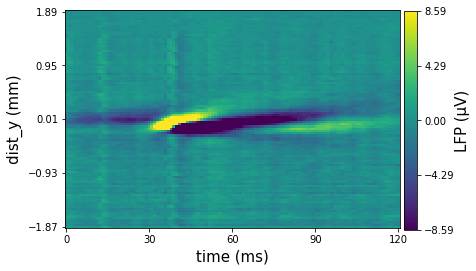

In [66]:
%matplotlib inline

cell_idx = 0

t = np.arange(test_data.shape[0])
print(test_data.shape)

ix = 1
ylim = [-1900,1900]
x_dist = np.unique(params.ELECTRODE_POSITION[:,0])
e_idx = ((params.ELECTRODE_POSITION[:,0]==x_dist[ix]) & 
         (params.ELECTRODE_POSITION[:,1]>=ylim[0]) & 
         (params.ELECTRODE_POSITION[:,1]<=ylim[1]))

print(e_idx.shape)
print(params.ELECTRODE_POSITION[e_idx, 1].shape)
print(t.shape)

_ = plot_lfp_heatmap(t,
                     params.ELECTRODE_POSITION[e_idx, 1],
                     test_data[:,e_idx], vlim='auto',
                     fontsize=15,labelpad=0,ticksize=10,nbins=5)